<a href="https://colab.research.google.com/github/shahchayan9/Dimensionality-Reduction/blob/main/ISOMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
brendan45774_how_much_it_cost_to_get_an_ad_on_google_path = kagglehub.dataset_download('brendan45774/how-much-it-cost-to-get-an-ad-on-google')
brendan45774_dictionary_and_pandas_csv_path = kagglehub.dataset_download('brendan45774/dictionary-and-pandas-csv')

print('Data source import complete.')


100%|██████████| 1.62k/1.62k [00:00<00:00, 2.44MB/s]

Extracting files...


100%|██████████| 316/316 [00:00<00:00, 249kB/s]

Extracting files...
Data source import complete.


# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
from time import time

from sklearn.datasets import fetch_lfw_people
from sklearn.manifold import Isomap
from sklearn.utils import check_random_state
from sklearn import manifold
from sklearn import datasets
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

from collections import OrderedDict
from functools import partial


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import seaborn as sns; sns.set()

print(__doc__)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Automatically created module for IPython interactive environment


# Isomap on Different Faces

In [ ]:
faces = fetch_lfw_people(min_faces_per_person=70)
faces.data.shape

(1288, 2914)

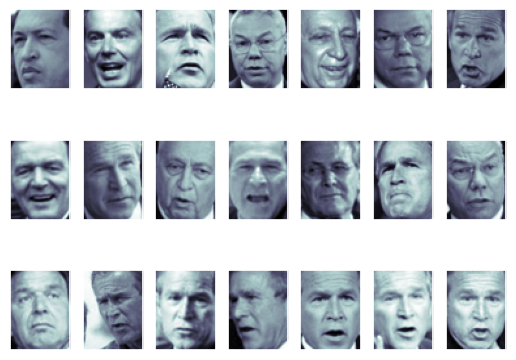

In [ ]:
fig, ax = plt.subplots(3, 7, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')

In [ ]:
def make_text(N=1000, rseed=42):
    fig, ax = plt.subplots(figsize=(7, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'ISOMAP', va='center', ha='center', weight='bold', size=85)
    fig.savefig('text.png')
    plt.close(fig)

    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('text.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(3 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

<ipython-input-7-d74eb4baafb5>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 40))


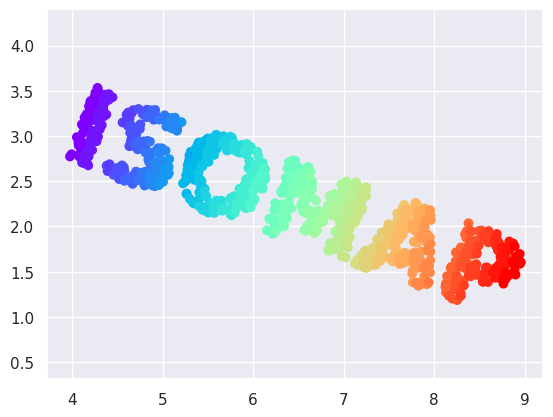

In [ ]:
X = make_text(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 40))
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, -20) + 3
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

In [ ]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()

    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

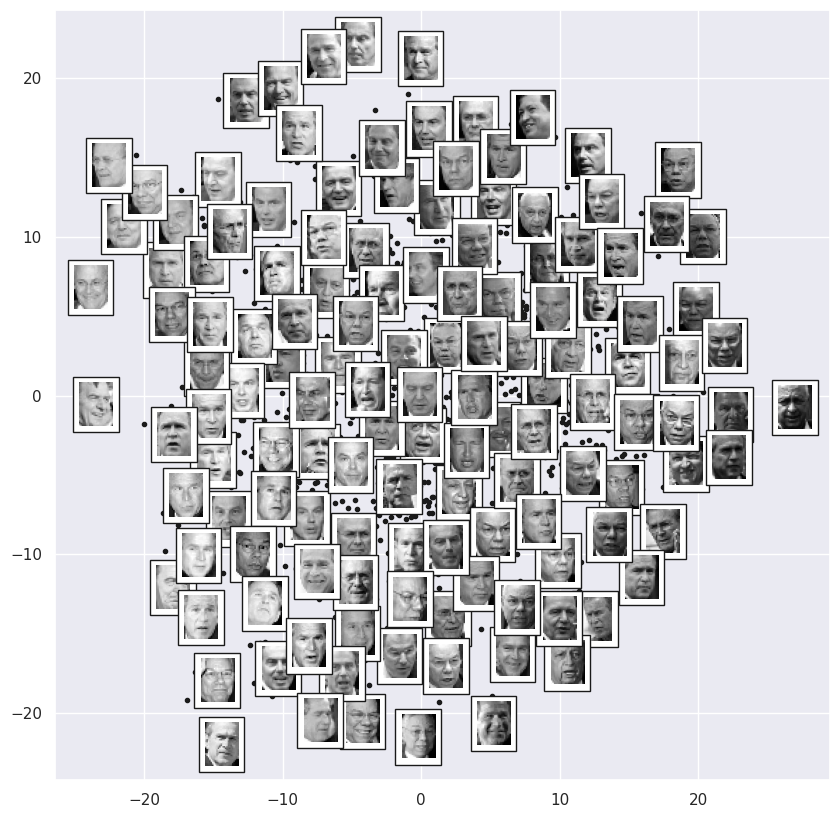

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

In [ ]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

# Scale and visualize the embedding vectors

In [ ]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

# Plot images of the digits

Text(0.5, 1.0, 'A selection from the 64-dimensional digits dataset')

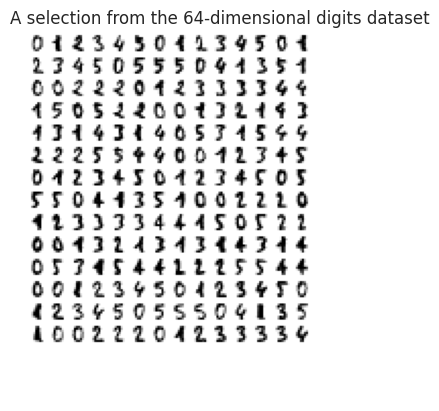

In [ ]:
n_img_per_row = 14
img = np.zeros((13 * n_img_per_row, 14 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 11 * i + 2
    for j in range(n_img_per_row):
        iy = 10 * j + 4
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

# Random 2D projection using a random unitary matrix

Computing random projection


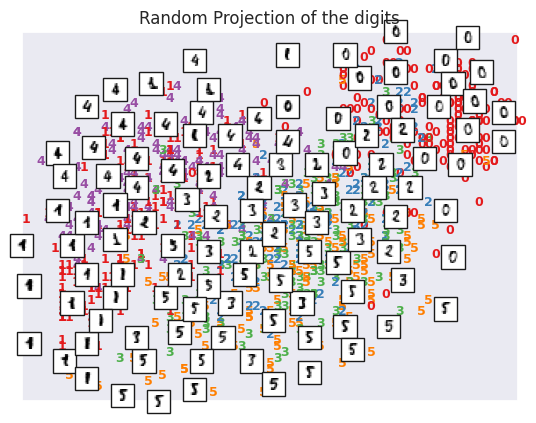

In [ ]:
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=64)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")

# Isomap projection of the digits dataset

Computing Isomap projection
Done.


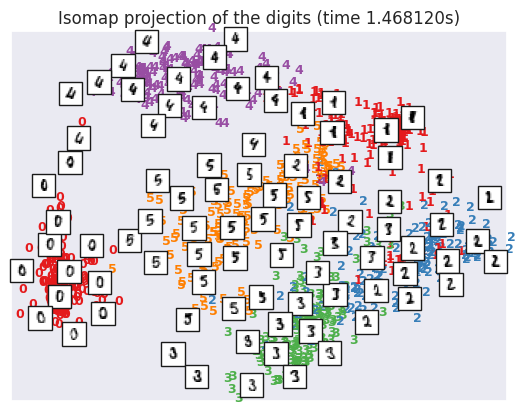

In [ ]:
print("Computing Isomap projection")
t6 = time()
X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2
                        ).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.6fs)" %
               (time() - t6))

# Comparing Manifold learning Isomap with other methods

Isomap: 0.7 sec
MDS: 3.3 sec
LLE: 0.18 sec


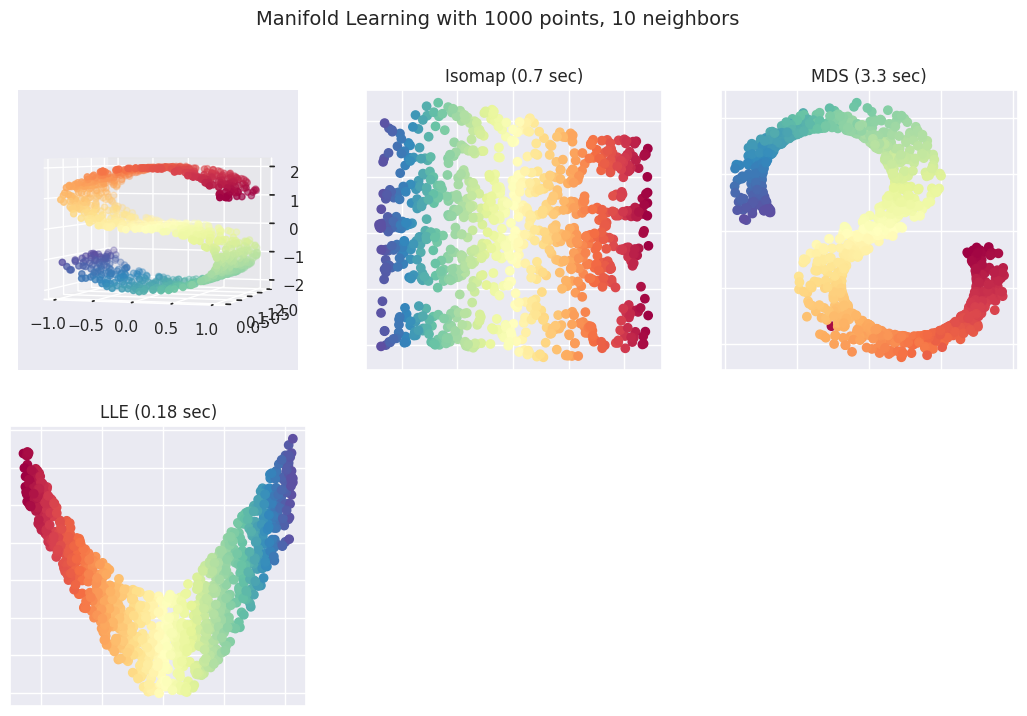

In [ ]:
# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=3)
n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(13,8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(231, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(3, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors=n_neighbors, n_components=n_components, eigen_solver='auto')

methods = OrderedDict()
methods['Isomap'] = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=110, n_init=1)
methods['LLE'] = LLE(method='standard')

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 3, 2 + i + (i > 2))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

standard: 0.11 sec
modified: 0.19 sec
ISO: 0.3 sec
MDS: 1.2 sec


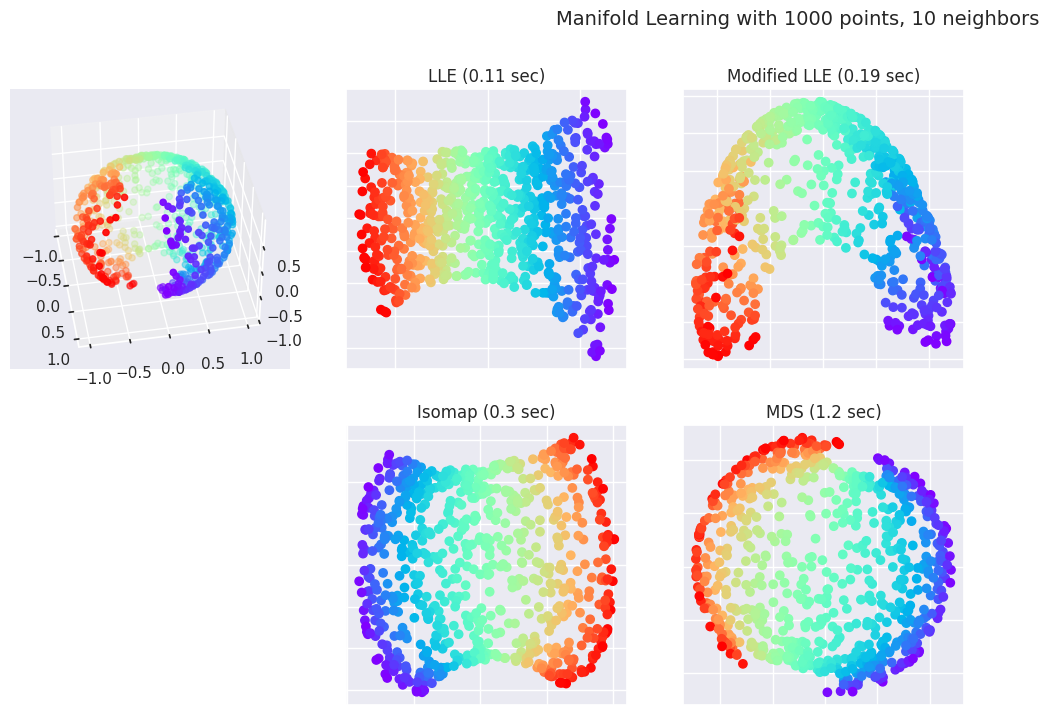

In [ ]:
# Next line to silence pyflakes.
Axes3D
# Variables for manifold learning.
n_neighbors = 10
n_samples = 1000

# Create our sphere.
random_state = check_random_state(2)
p = random_state.rand(n_samples) * (2 * np.pi - 0.85)
t = random_state.rand(n_samples) * np.pi

# Sever the poles from the sphere.
indices = ((t < (np.pi - (np.pi / 9))) & (t > ((np.pi / 7))))
colors = p[indices]
x, y, z = np.sin(t[indices]) * np.cos(p[indices]), \
    np.sin(t[indices]) * np.sin(p[indices]), \
    np.cos(t[indices])

# Plot our dataset.
fig = plt.figure(figsize=(21, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

ax = fig.add_subplot(251, projection='3d')
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T

# Perform Locally Linear Embedding Manifold learning
methods = ['standard', 'modified']
labels = ['LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    trans_data = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method=method).fit_transform(sphere_data).T
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

# Perform Isomap Manifold learning.
t0 = time()
trans_data = manifold.Isomap(n_neighbors=n_neighbors, n_components=3).fit_transform(sphere_data).T
t1 = time()
print("%s: %.2g sec" % ('ISO', t1 - t0))

ax = fig.add_subplot(257)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("%s (%.2g sec)" % ('Isomap', t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

# Perform Multi-dimensional scaling.
t0 = time()
mds = manifold.MDS(2, max_iter=100, n_init=1)
trans_data = mds.fit_transform(sphere_data).T
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(258)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

Resources: [sklearn.manifold.Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap)